## Estimate the Channel with a single-frequency signal

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import wave
from pydub import AudioSegment
from scipy import signal
from scipy.io import wavfile #audio i/o
from IPython.display import Audio #listening to audio
import thinkdsp
%matplotlib inline

Generate a 880 Hz sinusoid signal and use it as the source.

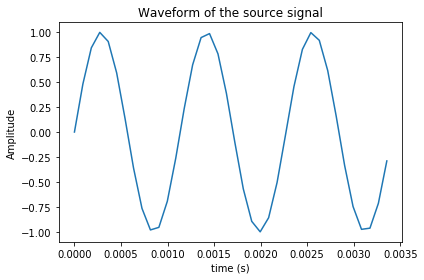

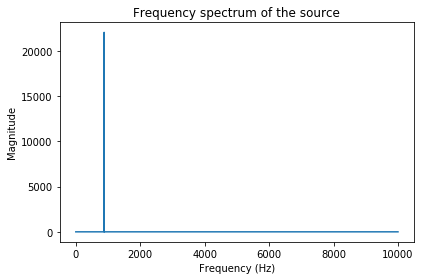

In [79]:
sin_sig = thinkdsp.SinSignal(freq = 880, amp = 1.0, offset = 0)
sin_sig.plot()
thinkdsp.decorate(xlabel = "time (s)", ylabel = "Amplitude", title = "Waveform of the source signal")
m_wav = sin_sig.make_wave(duration = 1, start = 0, framerate = 44100)
plt.figure()
m_spectrum = m_wav.make_spectrum()
m_spectrum.plot(high = 10000)
thinkdsp.decorate(xlabel = "Frequency (Hz)", ylabel = "Magnitude", title = "Frequency spectrum of the source")
m_wav.make_audio()

44100


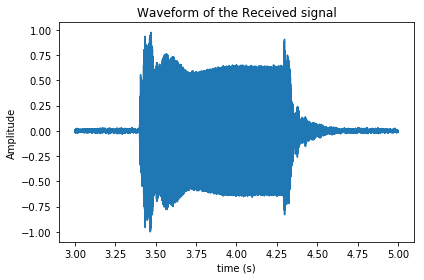

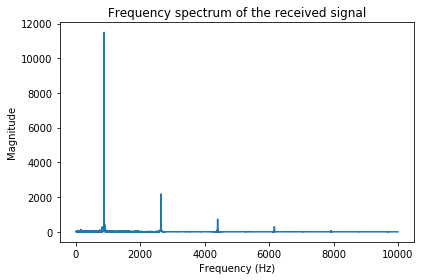

In [84]:
recv_wav_orig = thinkdsp.read_wave("Spot2_pitch_norm.wav")
recv_wav_seg = recv_wav_orig.segment(start = 3, duration = 2)
recv_wav_seg.plot()
thinkdsp.decorate(xlabel = "time (s)", ylabel = "Amplitude", title = "Waveform of the Received signal")
print(recv_wav_seg.framerate)
recv_spectrum = recv_wav_seg.make_spectrum()
plt.figure()
recv_spectrum.plot(high = 10000)
thinkdsp.decorate(xlabel = "Frequency (Hz)", ylabel = "Magnitude", title = "Frequency spectrum of the received signal")
recv_wav_seg.make_audio()

Observation: There are multiple impulse in the receive frequency spectrum with equal space. Why? This there any thing change the frequency of the signal.

Number of samples in the source signal: 44100
Number of samples in the received signal: 88200
Length of correlation:44101
Maximum correlation value: 11474.39189247034


Text(0.5,1,'Plot of the correlation in the maximum range [Maximum : Maximum + 4000]')

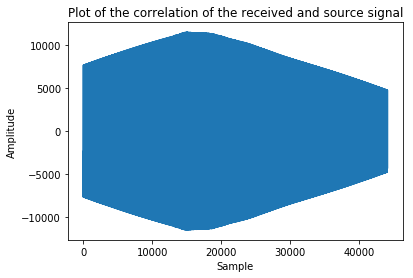

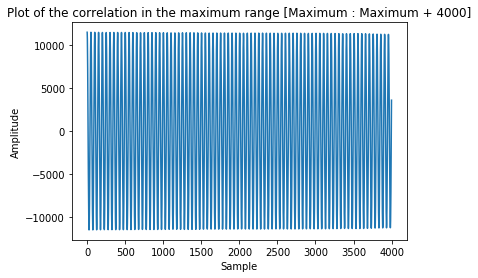

In [94]:
# Test correlation
corr = np.correlate(recv_wav_seg.ys,m_wav.ys,'valid')
start = list(corr).index(np.max(corr))
plt.figure()
plt.plot(corr)
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Plot of the correlation of the received and source signal")
print("Number of samples in the source signal: {}".format(len(m_wav.ys)))
print("Number of samples in the received signal: {}".format(len(recv_wav_seg.ys)))
print("Length of correlation:{}".format(len(corr)))
print("Maximum correlation value: {}".format(np.max(corr)))
plt.figure()
plt.plot(corr[start:start+4000])
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.title("Plot of the correlation in the maximum range [Maximum : Maximum + 4000]")

Observation: The maximum correlation value indicates the complete overlap of the source and received signal. After the maximum value, there's a relative flat range of value that has similar correlation values.Extract the recevied signal starting from the index of maximum correlation value to a duration of 1s

[11474.39189247]


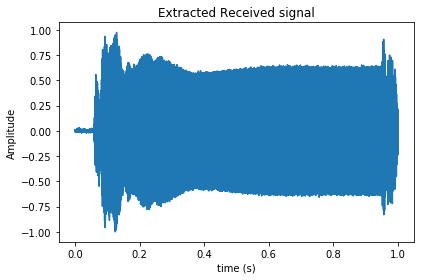

In [95]:
extracted_wav = thinkdsp.Wave(ys = recv_wav_seg.ys[start:start+44100], framerate = 44100)
extracted_wav.plot()
thinkdsp.decorate(xlabel = "time (s)", ylabel = "Amplitude", title = "Extracted Received signal")
print(np.correlate(extracted_wav.ys, m_wav.ys))

Observation: The extracted received signal does not exactly overlapped with the source signal. There's a small range ahead that only contains the noise.

44100


Text(0.5,1,'Channel impulse response')

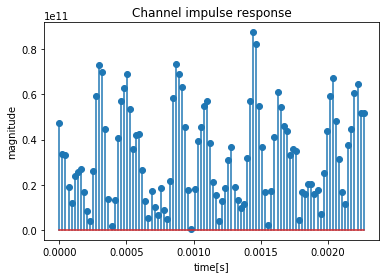

In [96]:
# Estimate the channel
h = np.fft.ifft(np.fft.fft(extracted_wav.ys)/np.fft.fft(m_wav.ys))
print(len(h))
h = np.abs(h[:100])
time = len(h)/44100
t = np.linspace(0, time, len(h))
plt.stem(t, h)
plt.xlabel('time[s]')
plt.ylabel('magnitude')
plt.title('Channel impulse response')

Observation: The obtained Channel impulse response does not look like what i have expected. It seems to be ramdomly distributed in the whole interval. Also, the magnitude is surprisingly large.

Try another method: take a stable part of the received signal and use it to estimate the channel

0.0045351473922902496


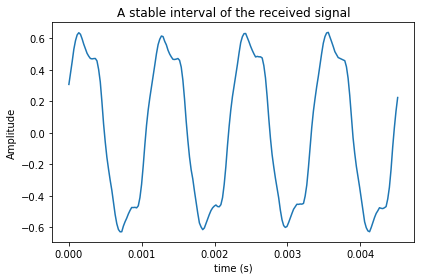

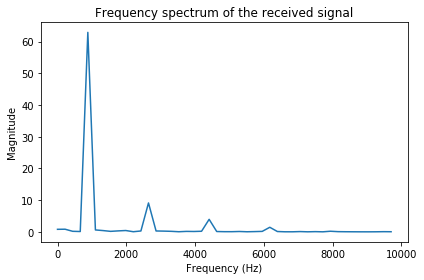

In [99]:
extracted_wav2 = thinkdsp.Wave(ys = extracted_wav.ys[int(44100*0.8):int(44100*0.8)+200], framerate = 44100)
print(extracted_wav2.duration)
extracted_wav2.plot()
thinkdsp.decorate(xlabel = "time (s)", ylabel = "Amplitude", title = "A stable interval of the received signal")
extracted_spectrum2 = extracted_wav2.make_spectrum()
plt.figure()
extracted_spectrum2.plot(high = 10000)
thinkdsp.decorate(xlabel = "Frequency (Hz)", ylabel = "Magnitude", title = "Frequency spectrum of the received signal")

Text(0.5,1,'Channel impulse response')

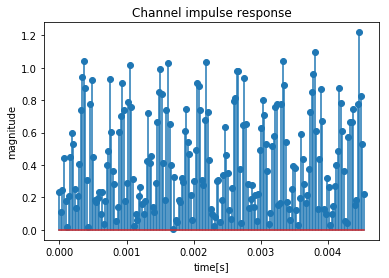

In [100]:
transmitted_sig = sin_sig.make_wave(duration = 4/880, start = 0, framerate = 44100)
h = np.fft.ifft(np.fft.fft(extracted_wav2.ys)/np.fft.fft(transmitted_sig.ys))
h = np.abs(h)
time = len(h)/44100
t = np.linspace(0, time, len(h))
plt.stem(t, h)
plt.xlabel('time[s]')
plt.ylabel('magnitude')
plt.title('Channel impulse response')